In [ ]:
!pip install xgboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 31.2 MB/s eta 0:00:00


In [ ]:
#Imports & Load Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# New Libraries for Advanced Models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression # The "Linear" Classifier
from xgboost import XGBClassifier
import optuna # The advanced tuner

# Sklearn Modules
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [ ]:
import pandas as pd

# Load Data
# If using Google Colab, make sure you uploaded the file on the left first!
try:
    df = pd.read_csv('breast-cancer.csv')
    print("--- Data Loaded Successfully ---")
    print(df.head())
except FileNotFoundError:
    print("Error: 'breast-cancer.csv' not found. Please upload the file.")

--- Data Loaded Successfully ---
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

 # PRE-PROCESSING
# 1. Clean Data
df.dropna(axis=1, how='all', inplace=True) # Drop empty columns
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True) # Drop ID
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True) # Drop duplicates
df.fillna(df.mean(numeric_only=True), inplace=True) # Handle Missing Values

# 2. Encode Target
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

# 3. Define Features & Target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# 4. Scale Data (MANDATORY for SVM and K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Data Cleaned, Scaled, and Split.")

Data Cleaned, Scaled, and Split.


/tmp/ipython-input-3139171439.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, ax=axes[0], palette='viridis')


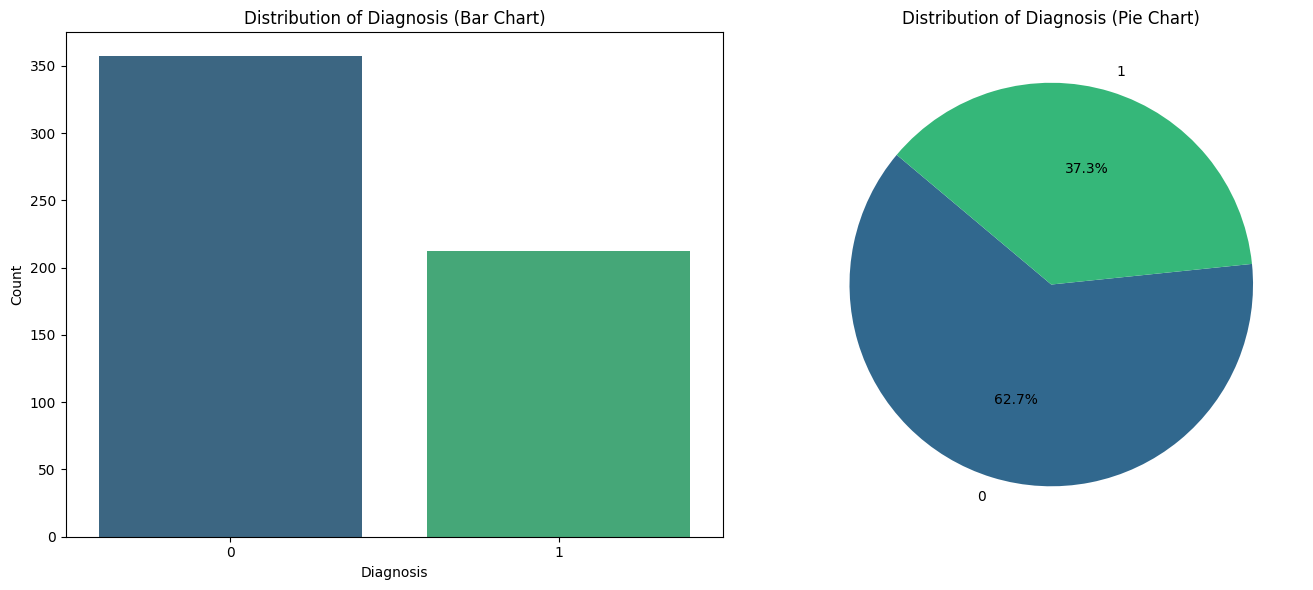

In [ ]:
#Data Visualisation
# Count the occurrences of each diagnosis
diagnosis_counts = df['diagnosis'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar Chart
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Diagnosis (Bar Chart)')
axes[0].set_xlabel('Diagnosis')
axes[0].set_ylabel('Count')

# Pie Chart
axes[1].pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 2))
axes[1].set_title('Distribution of Diagnosis (Pie Chart)')

# Save the figure
plt.tight_layout()
plt.savefig('diagnosis_distribution.png')

/tmp/ipython-input-1663148521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
/tmp/ipython-input-1663148521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
/tmp/ipython-input-1663148521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
/tmp/ipython-input-1663148521.py:15: FutureWar

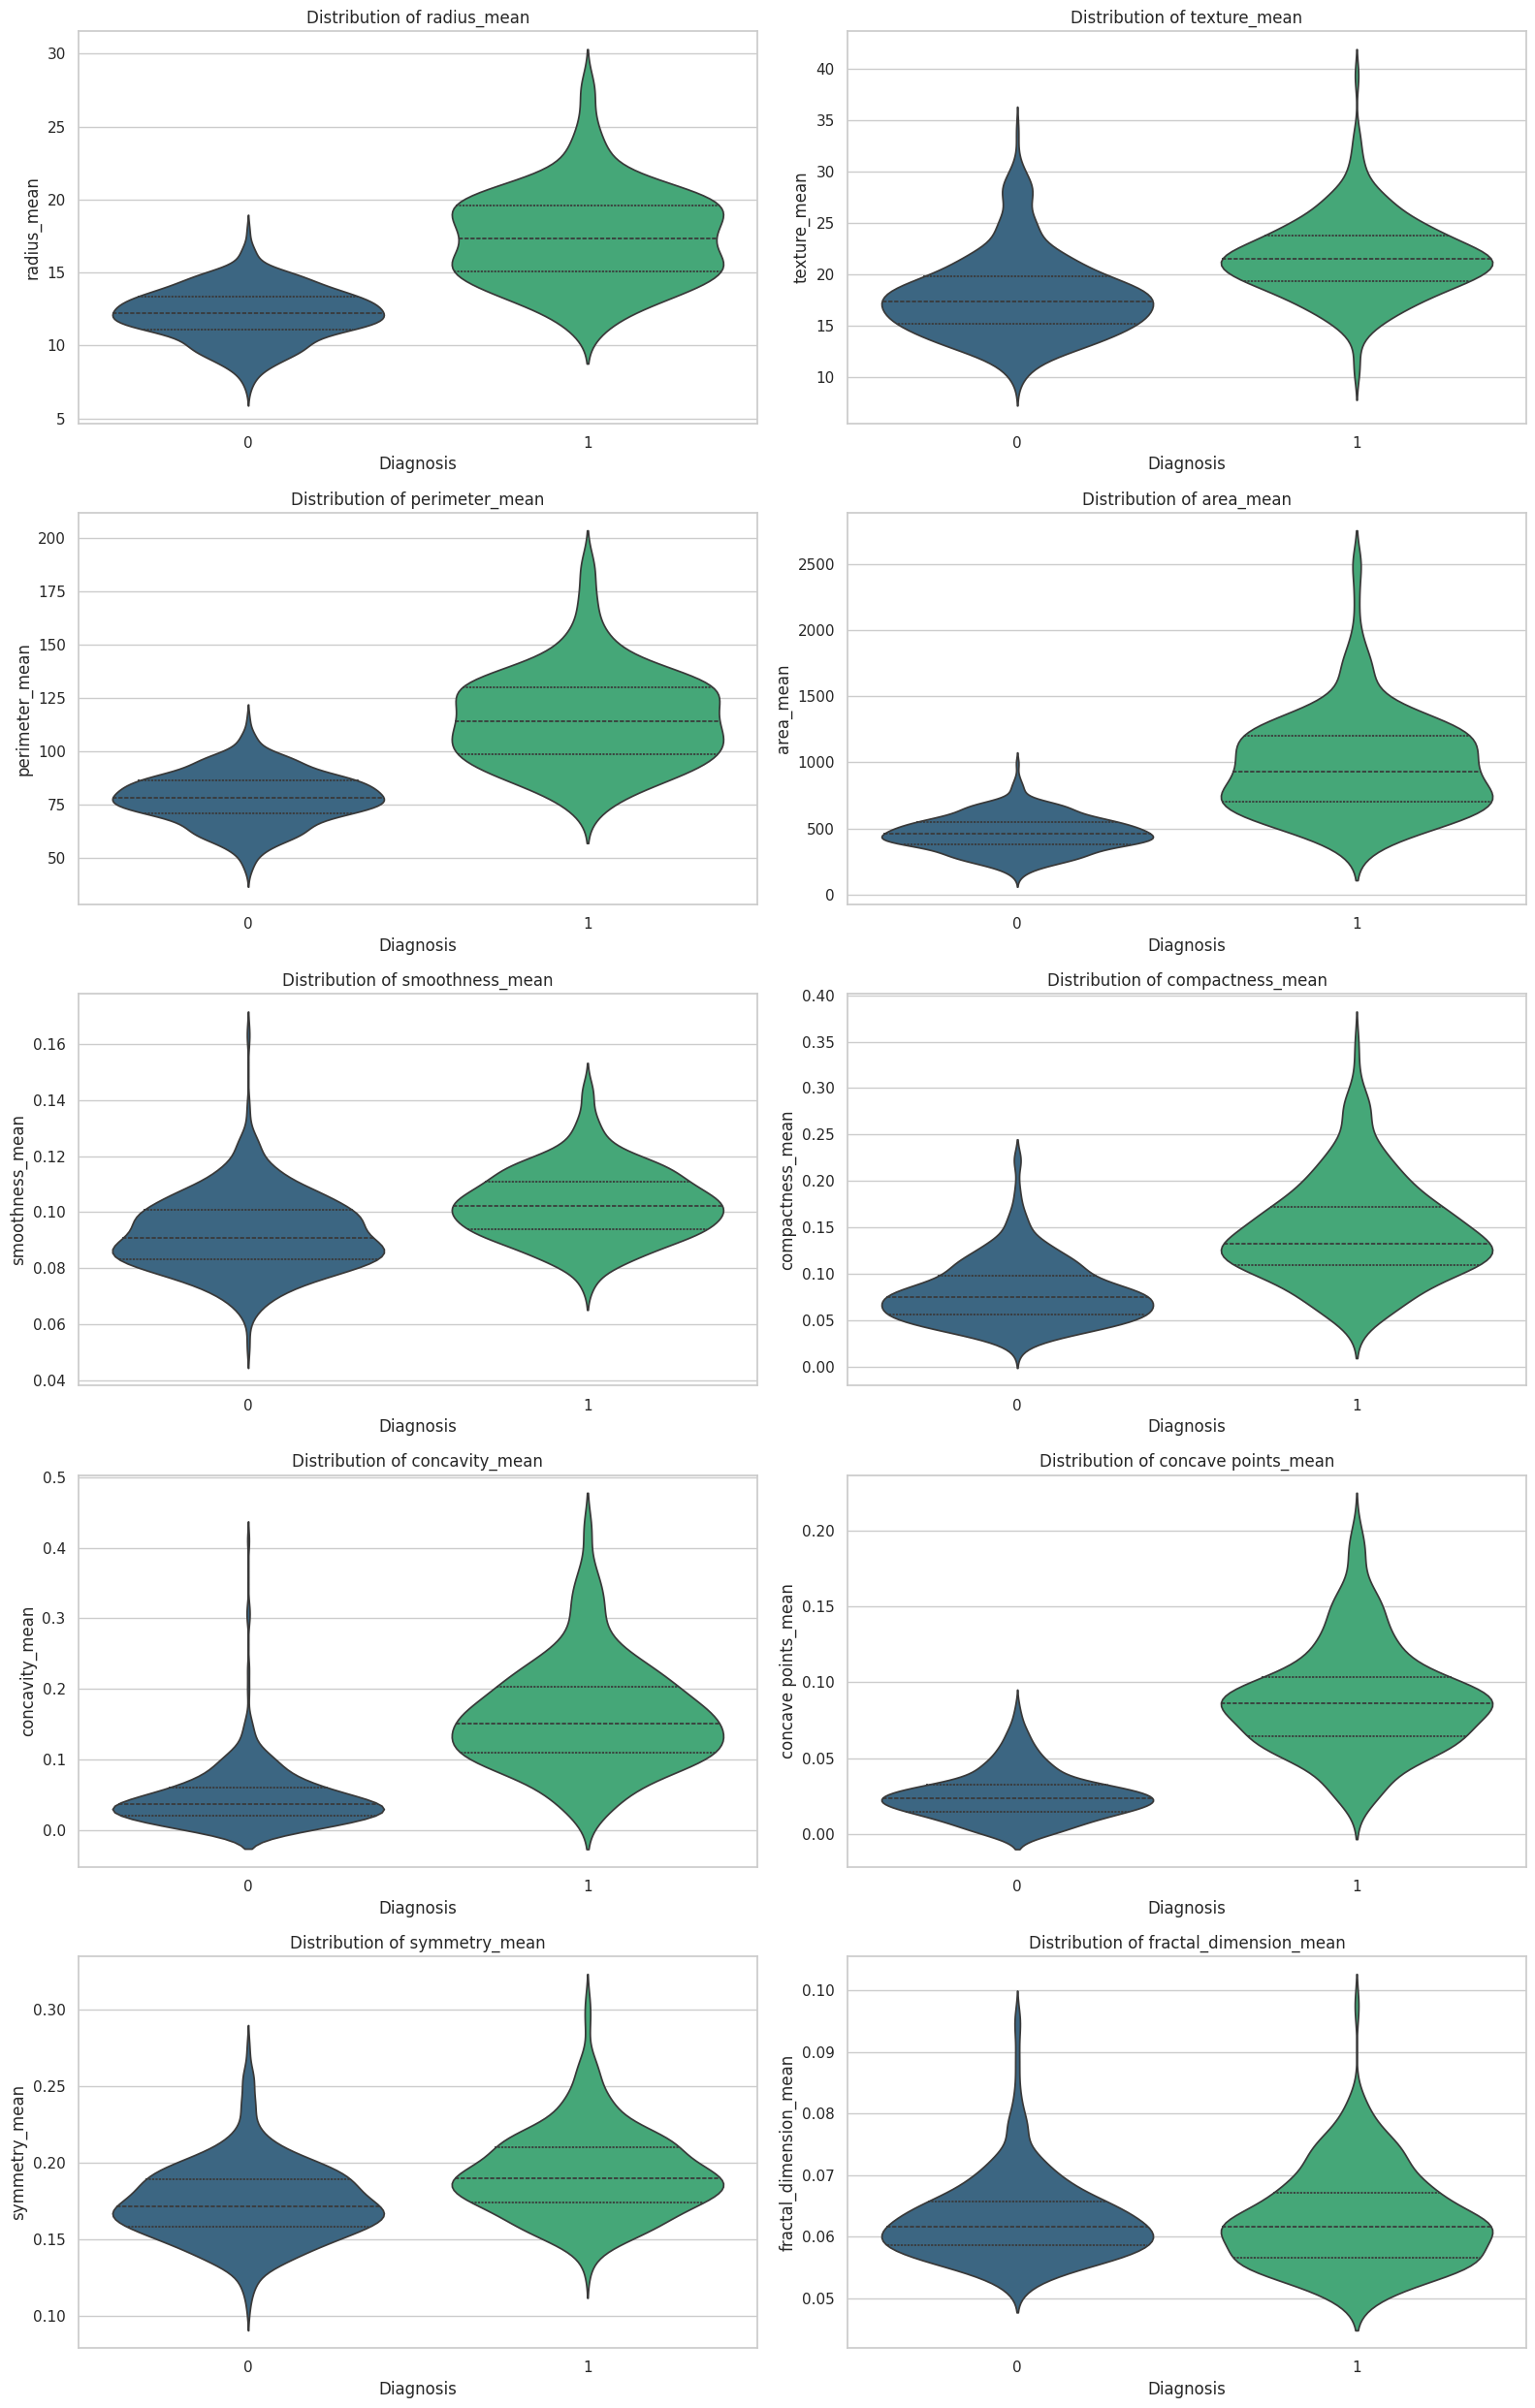

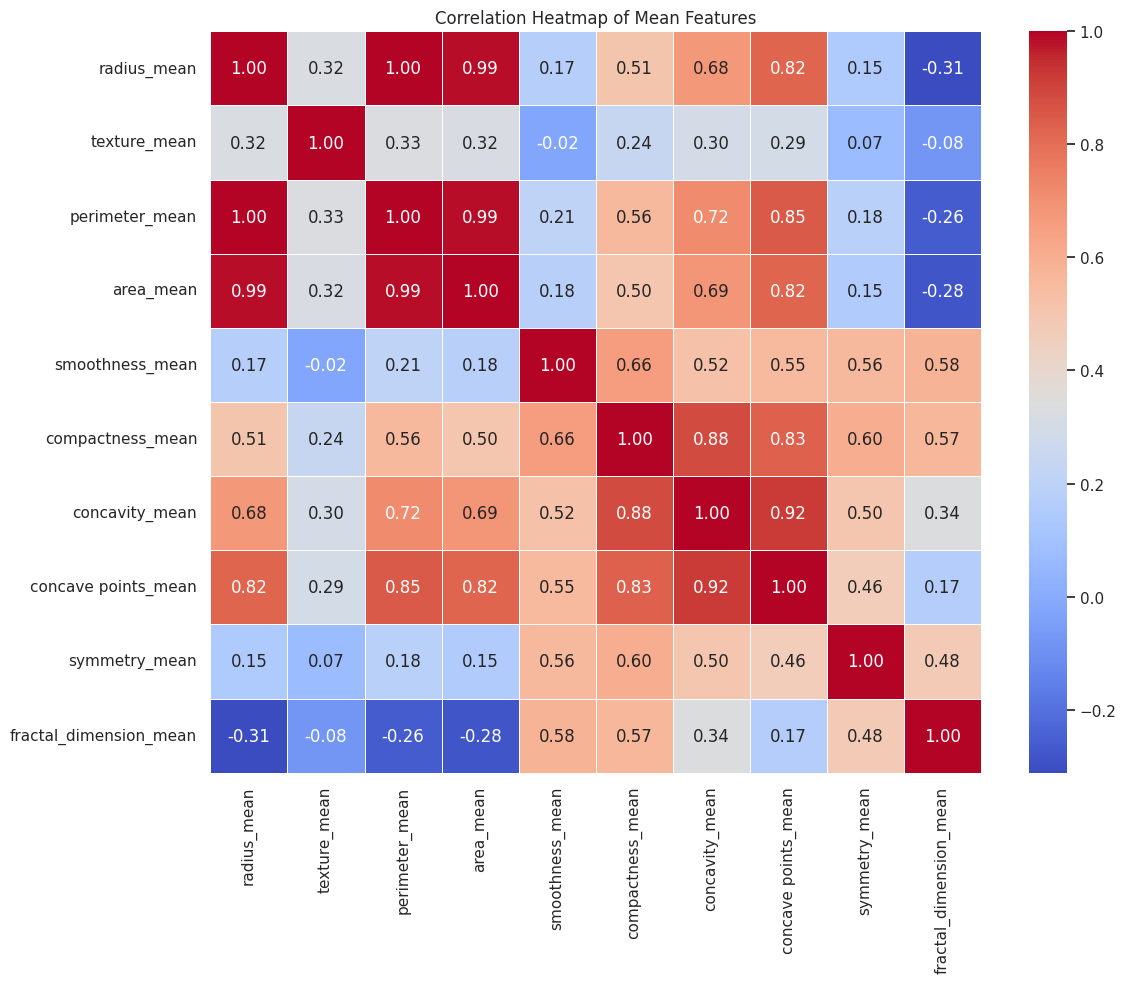

In [ ]:
#Visualisation for all of the attributes mean
# List of all mean features
features_mean = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'
]

# 1. Violin Plots Visualization
# Setting up the subplot grid (5 rows, 2 columns)
fig, axes = plt.subplots(5, 2, figsize=(16, 25))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i, feature in enumerate(features_mean):
    sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Diagnosis')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.savefig('violinplots_all_means.png')

# 2. Correlation Heatmap
# To see if they "look same" in terms of correlation
plt.figure(figsize=(12, 10))
# Calculate correlation matrix only for the mean features
corr_matrix = df[features_mean].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Mean Features')
plt.tight_layout()
plt.savefig('correlation_heatmap_means.png')

/tmp/ipython-input-1204167291.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
/tmp/ipython-input-1204167291.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
/tmp/ipython-input-1204167291.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
/tmp/ipython-input-1204167291.py:21: FutureWar

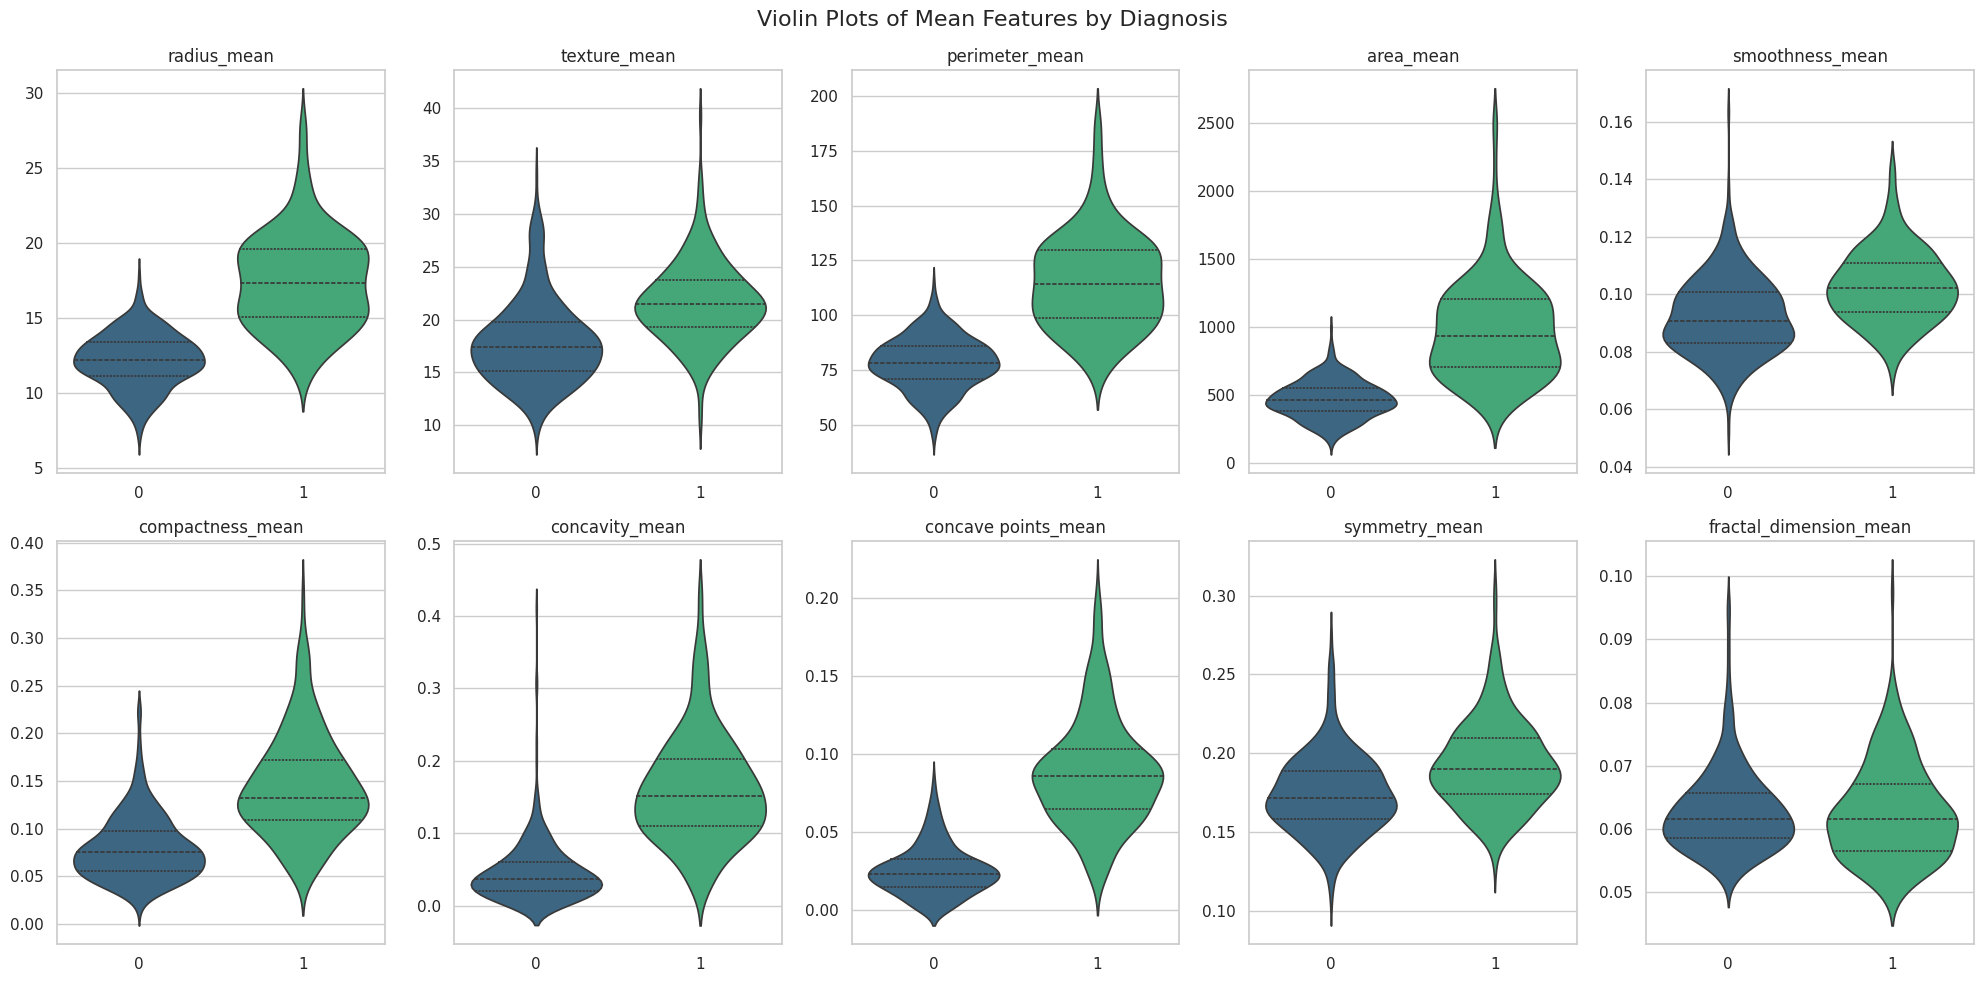

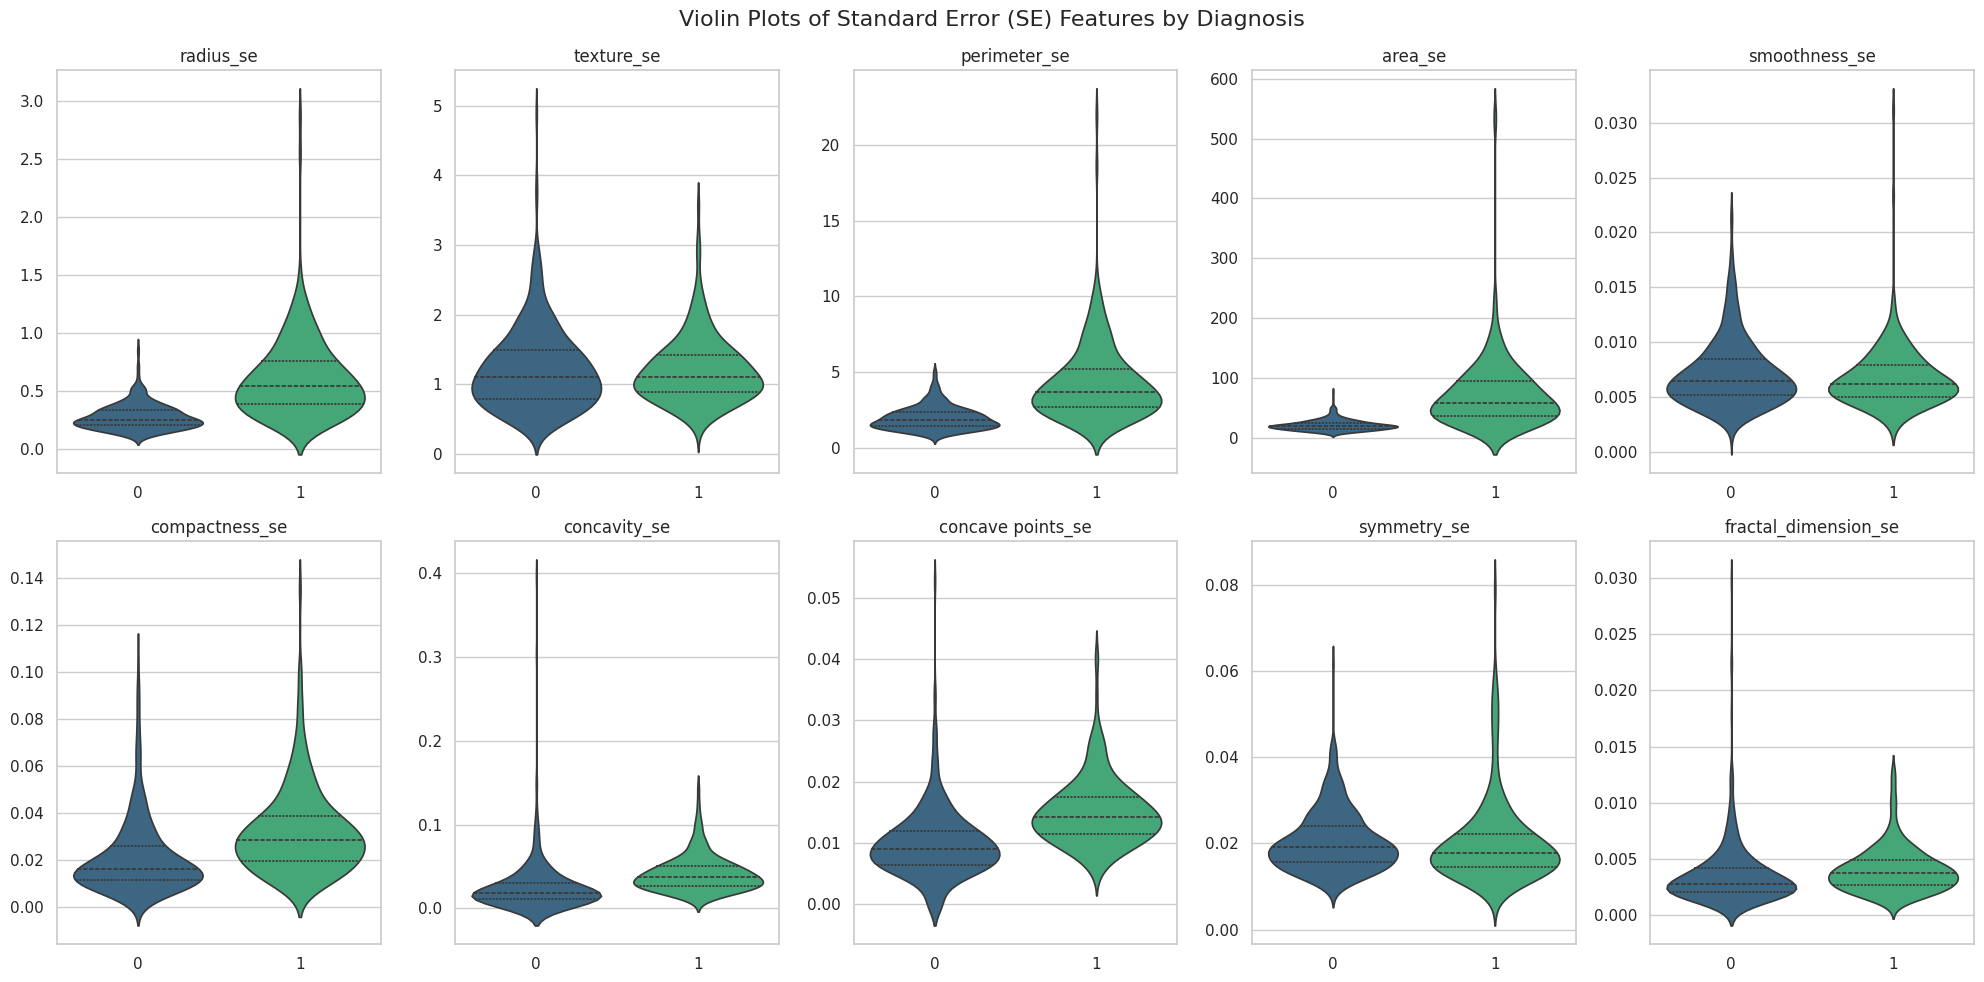

In [ ]:
#Visualisation for all of the attributes se
# List of base feature names provided by the user
base_features = [
    'radius', 'texture', 'perimeter', 'area', 'smoothness',
    'compactness', 'concavity', 'concave points', 'symmetry', 'fractal_dimension'
]

# Create lists for _mean and _se columns
features_mean = [f + '_mean' for f in base_features]
features_se = [f + '_se' for f in base_features]

# Function to create violin plots grid
def plot_violins(features, title_suffix, filename):
    n_cols = 5
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        if feature in df.columns:
            sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='viridis', inner="quart")
            axes[i].set_title(f'{feature}')
            axes[i].set_xlabel('') # Remove x-label to reduce clutter
            axes[i].set_ylabel('') # Remove y-label to reduce clutter
        else:
            axes[i].set_visible(False) # Hide empty subplots if any

    fig.suptitle(f'Violin Plots of {title_suffix} Features by Diagnosis', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92) # Adjust for suptitle
    plt.savefig(filename)

# Plot for Mean features
plot_violins(features_mean, 'Mean', 'violinplots_mean_all.png')

# Plot for SE features
plot_violins(features_se, 'Standard Error (SE)', 'violinplots_se_all.png')

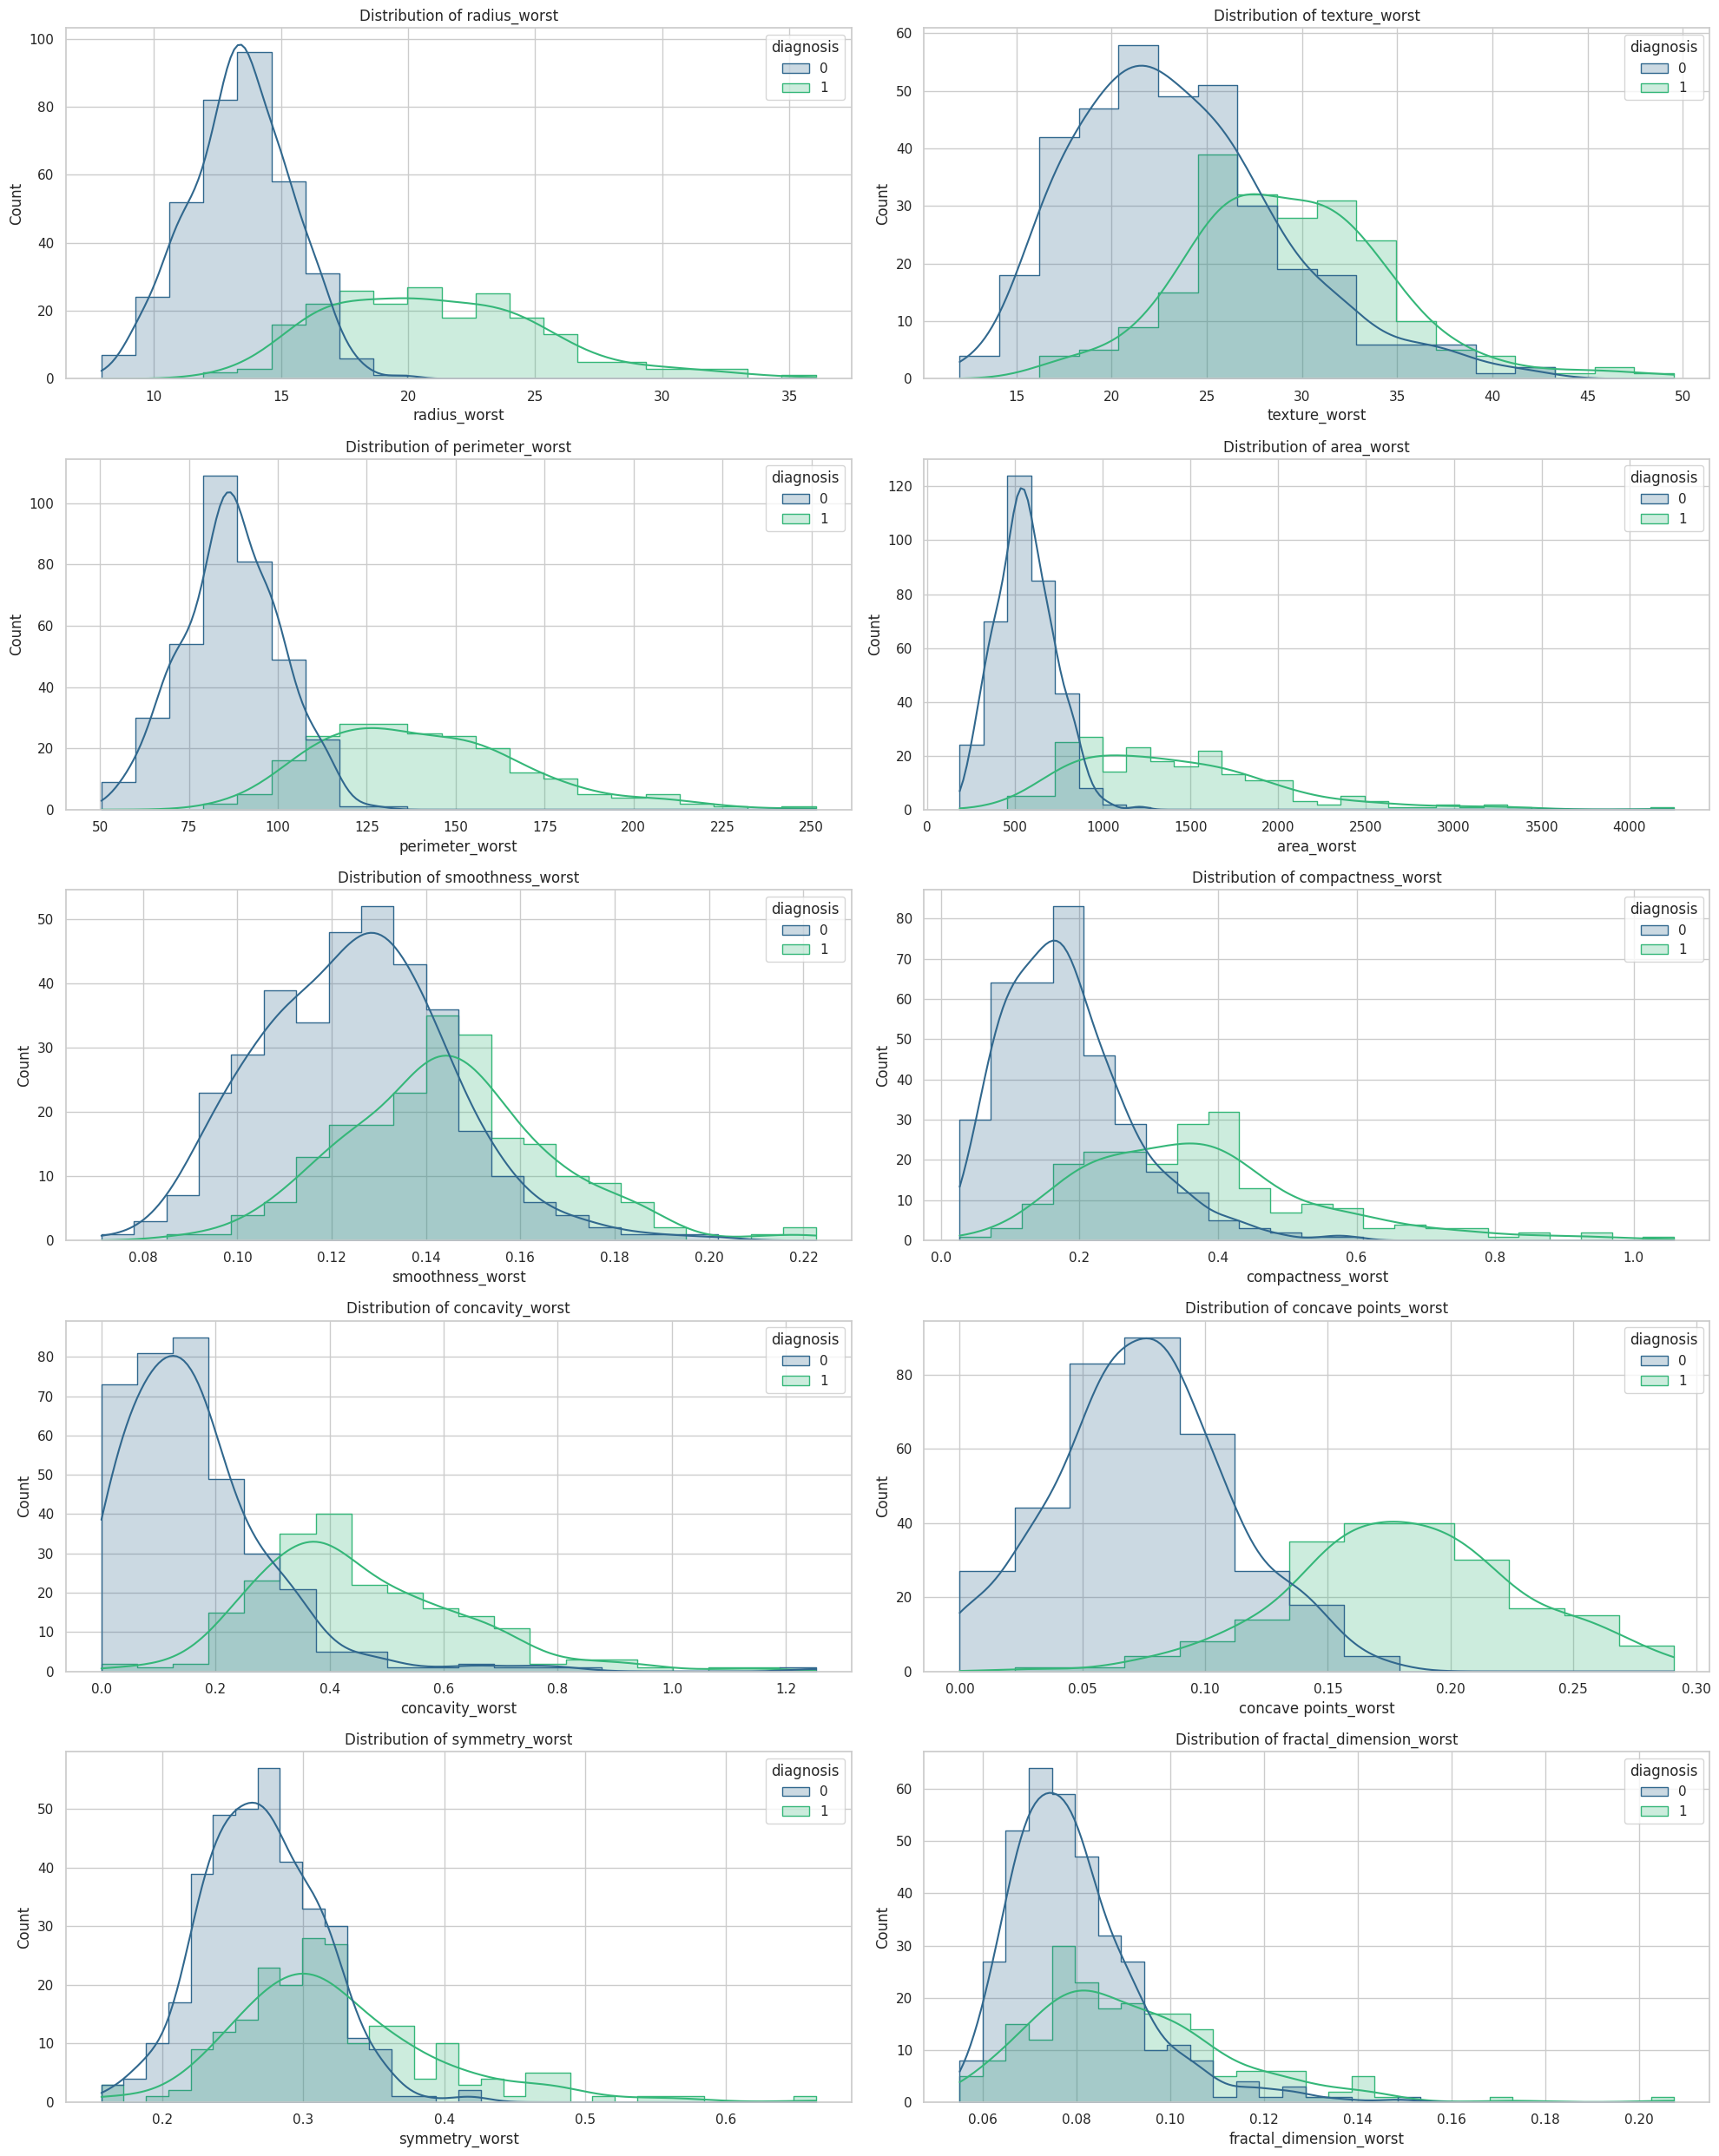

In [ ]:
##Visualisation for all of the attributes worst
# List of 'worst' features
worst_features = [
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
    'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

# Set up the figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, feature in enumerate(worst_features):
    # Plot histogram with KDE
    sns.histplot(data=df, x=feature, hue='diagnosis', kde=True, element="step", ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('worst_features_distributions.png')

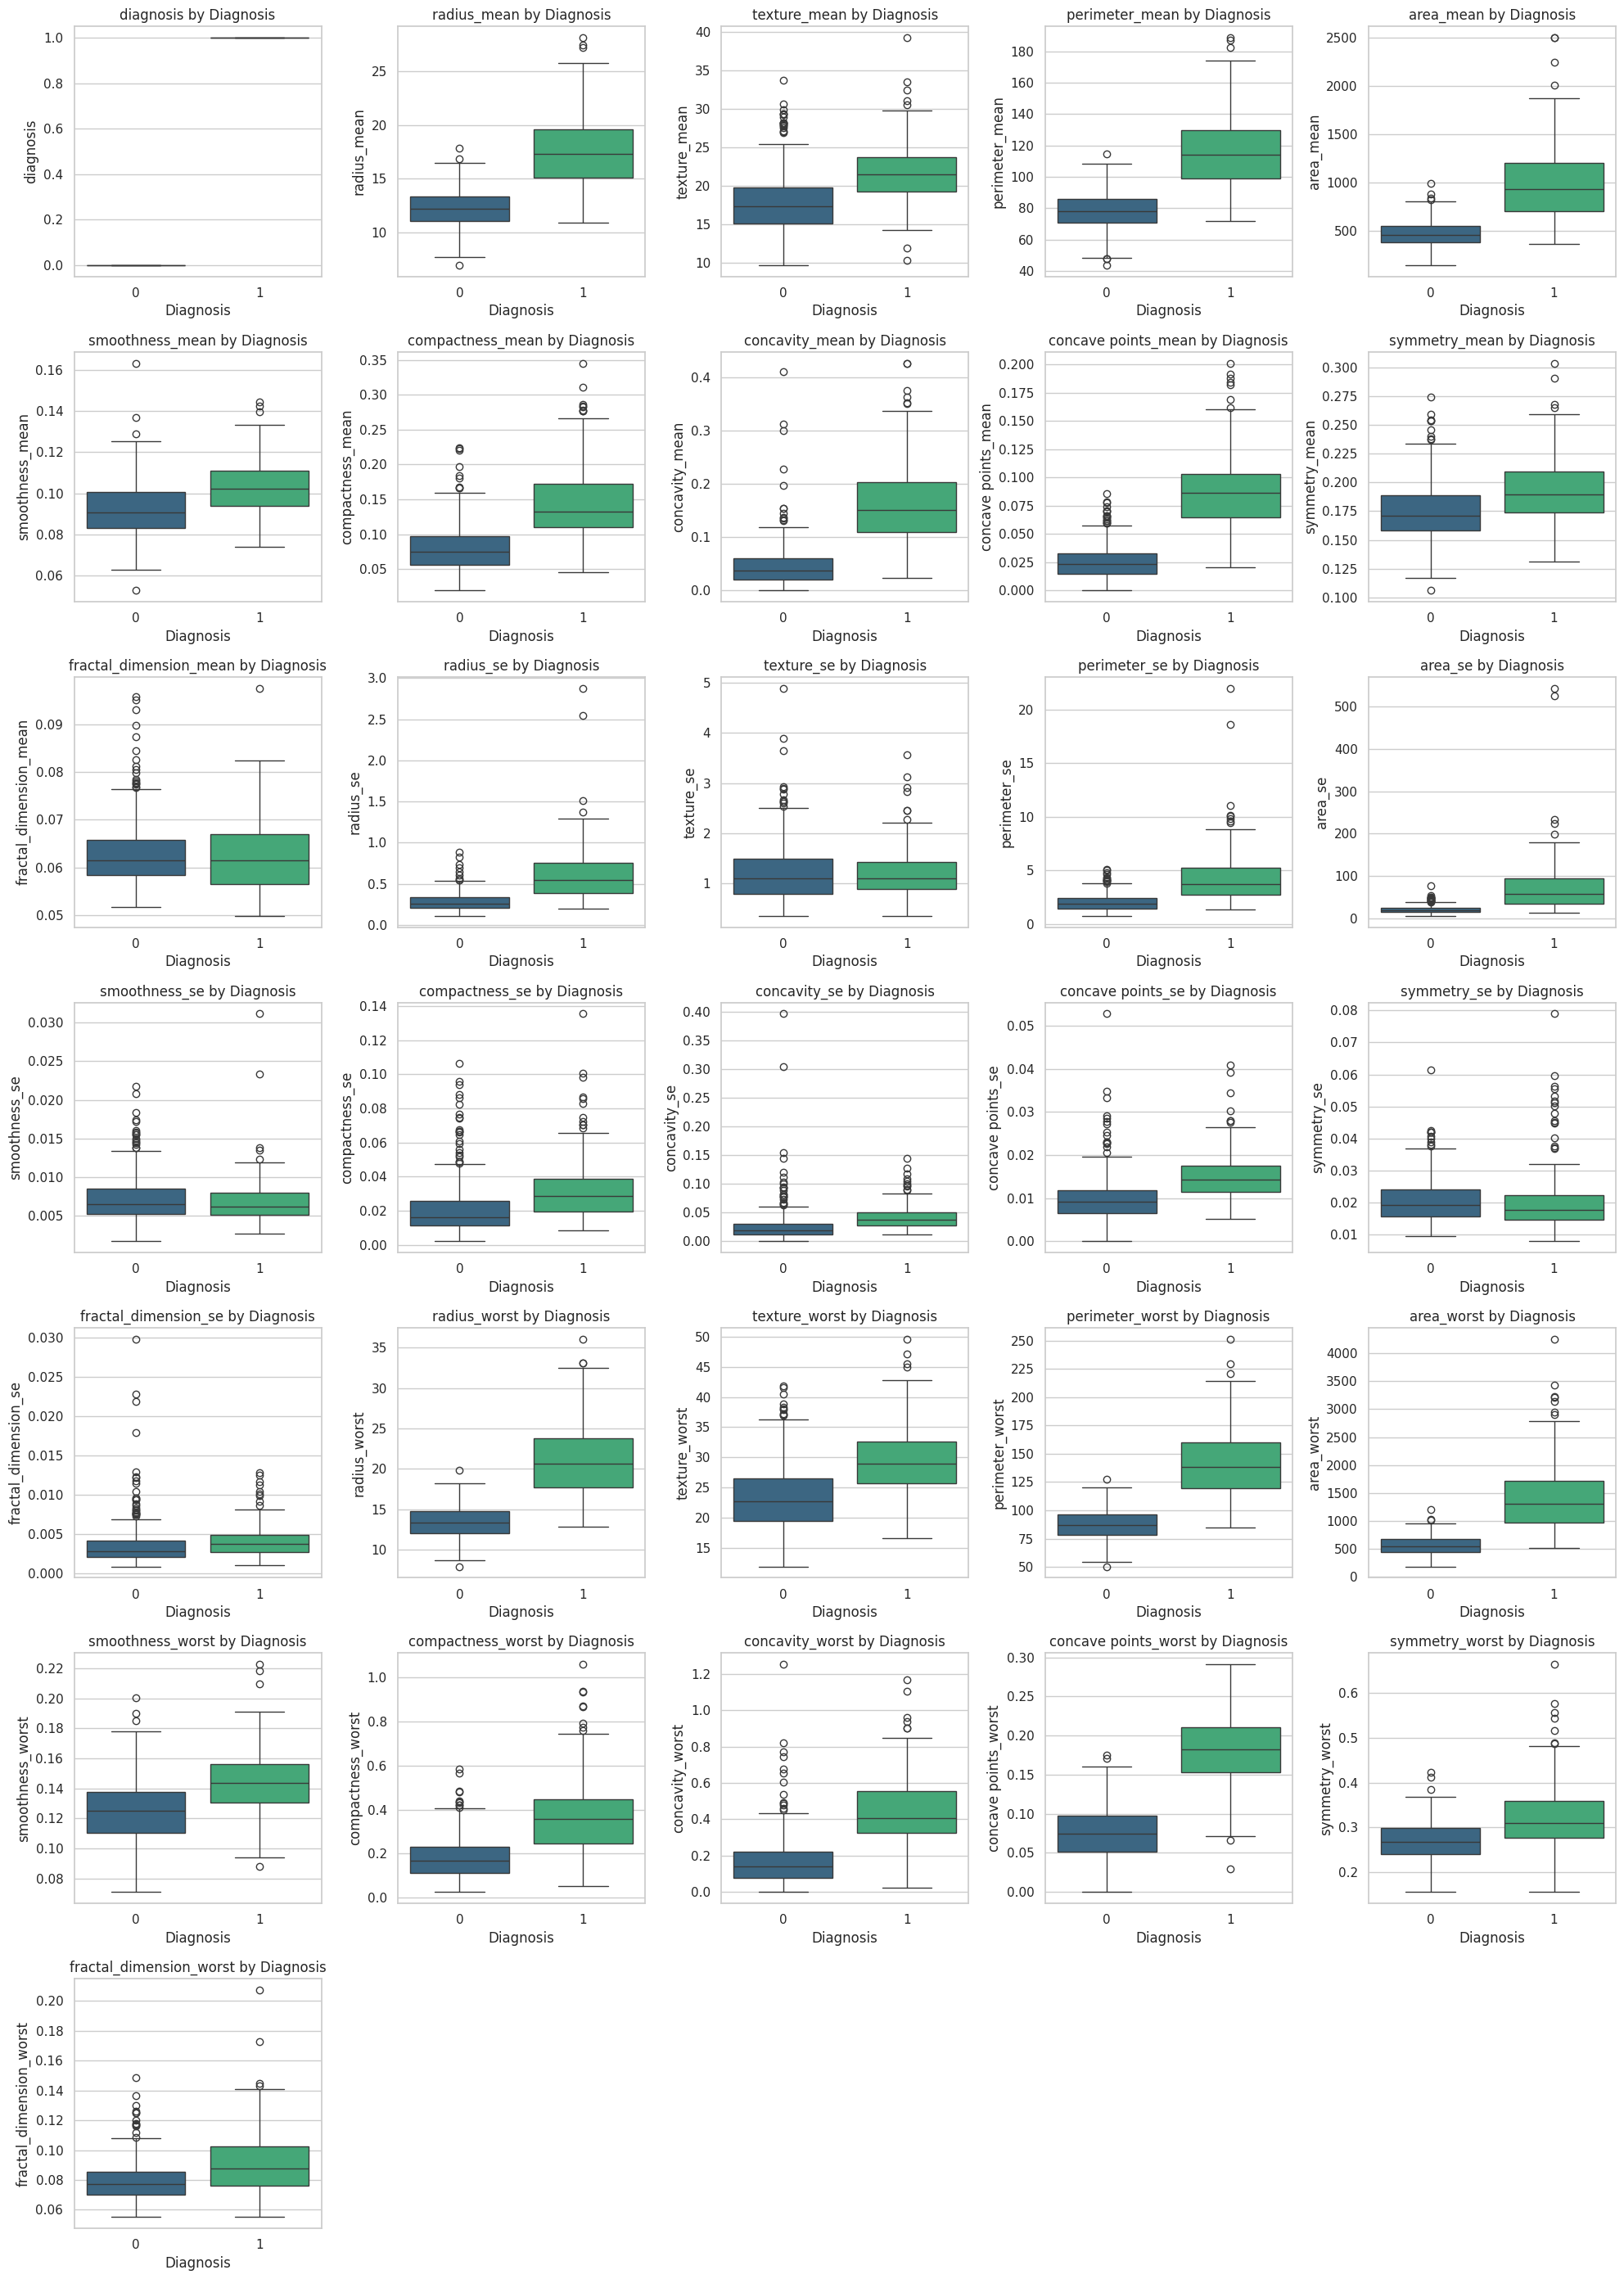

In [ ]:
import math

#Box plots for numerical features by Result
# Identify numerical features, excluding 'id' which is not useful for analysis
# and 'diagnosis' which is the categorical target
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'id' in numerical_features:
    numerical_features.remove('id')

# Calculate grid dimensions
n_features = len(numerical_features)
n_cols = 5
n_rows = math.ceil(n_features / n_cols)

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Generate box plots
for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, x='diagnosis', y=feature, hue='diagnosis', ax=axes[i], palette='viridis', legend=False)
    axes[i].set_title(f'{feature} by Diagnosis')
    axes[i].set_xlabel('Diagnosis')
    axes[i].set_ylabel(feature)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('numerical_features_boxplots.png')

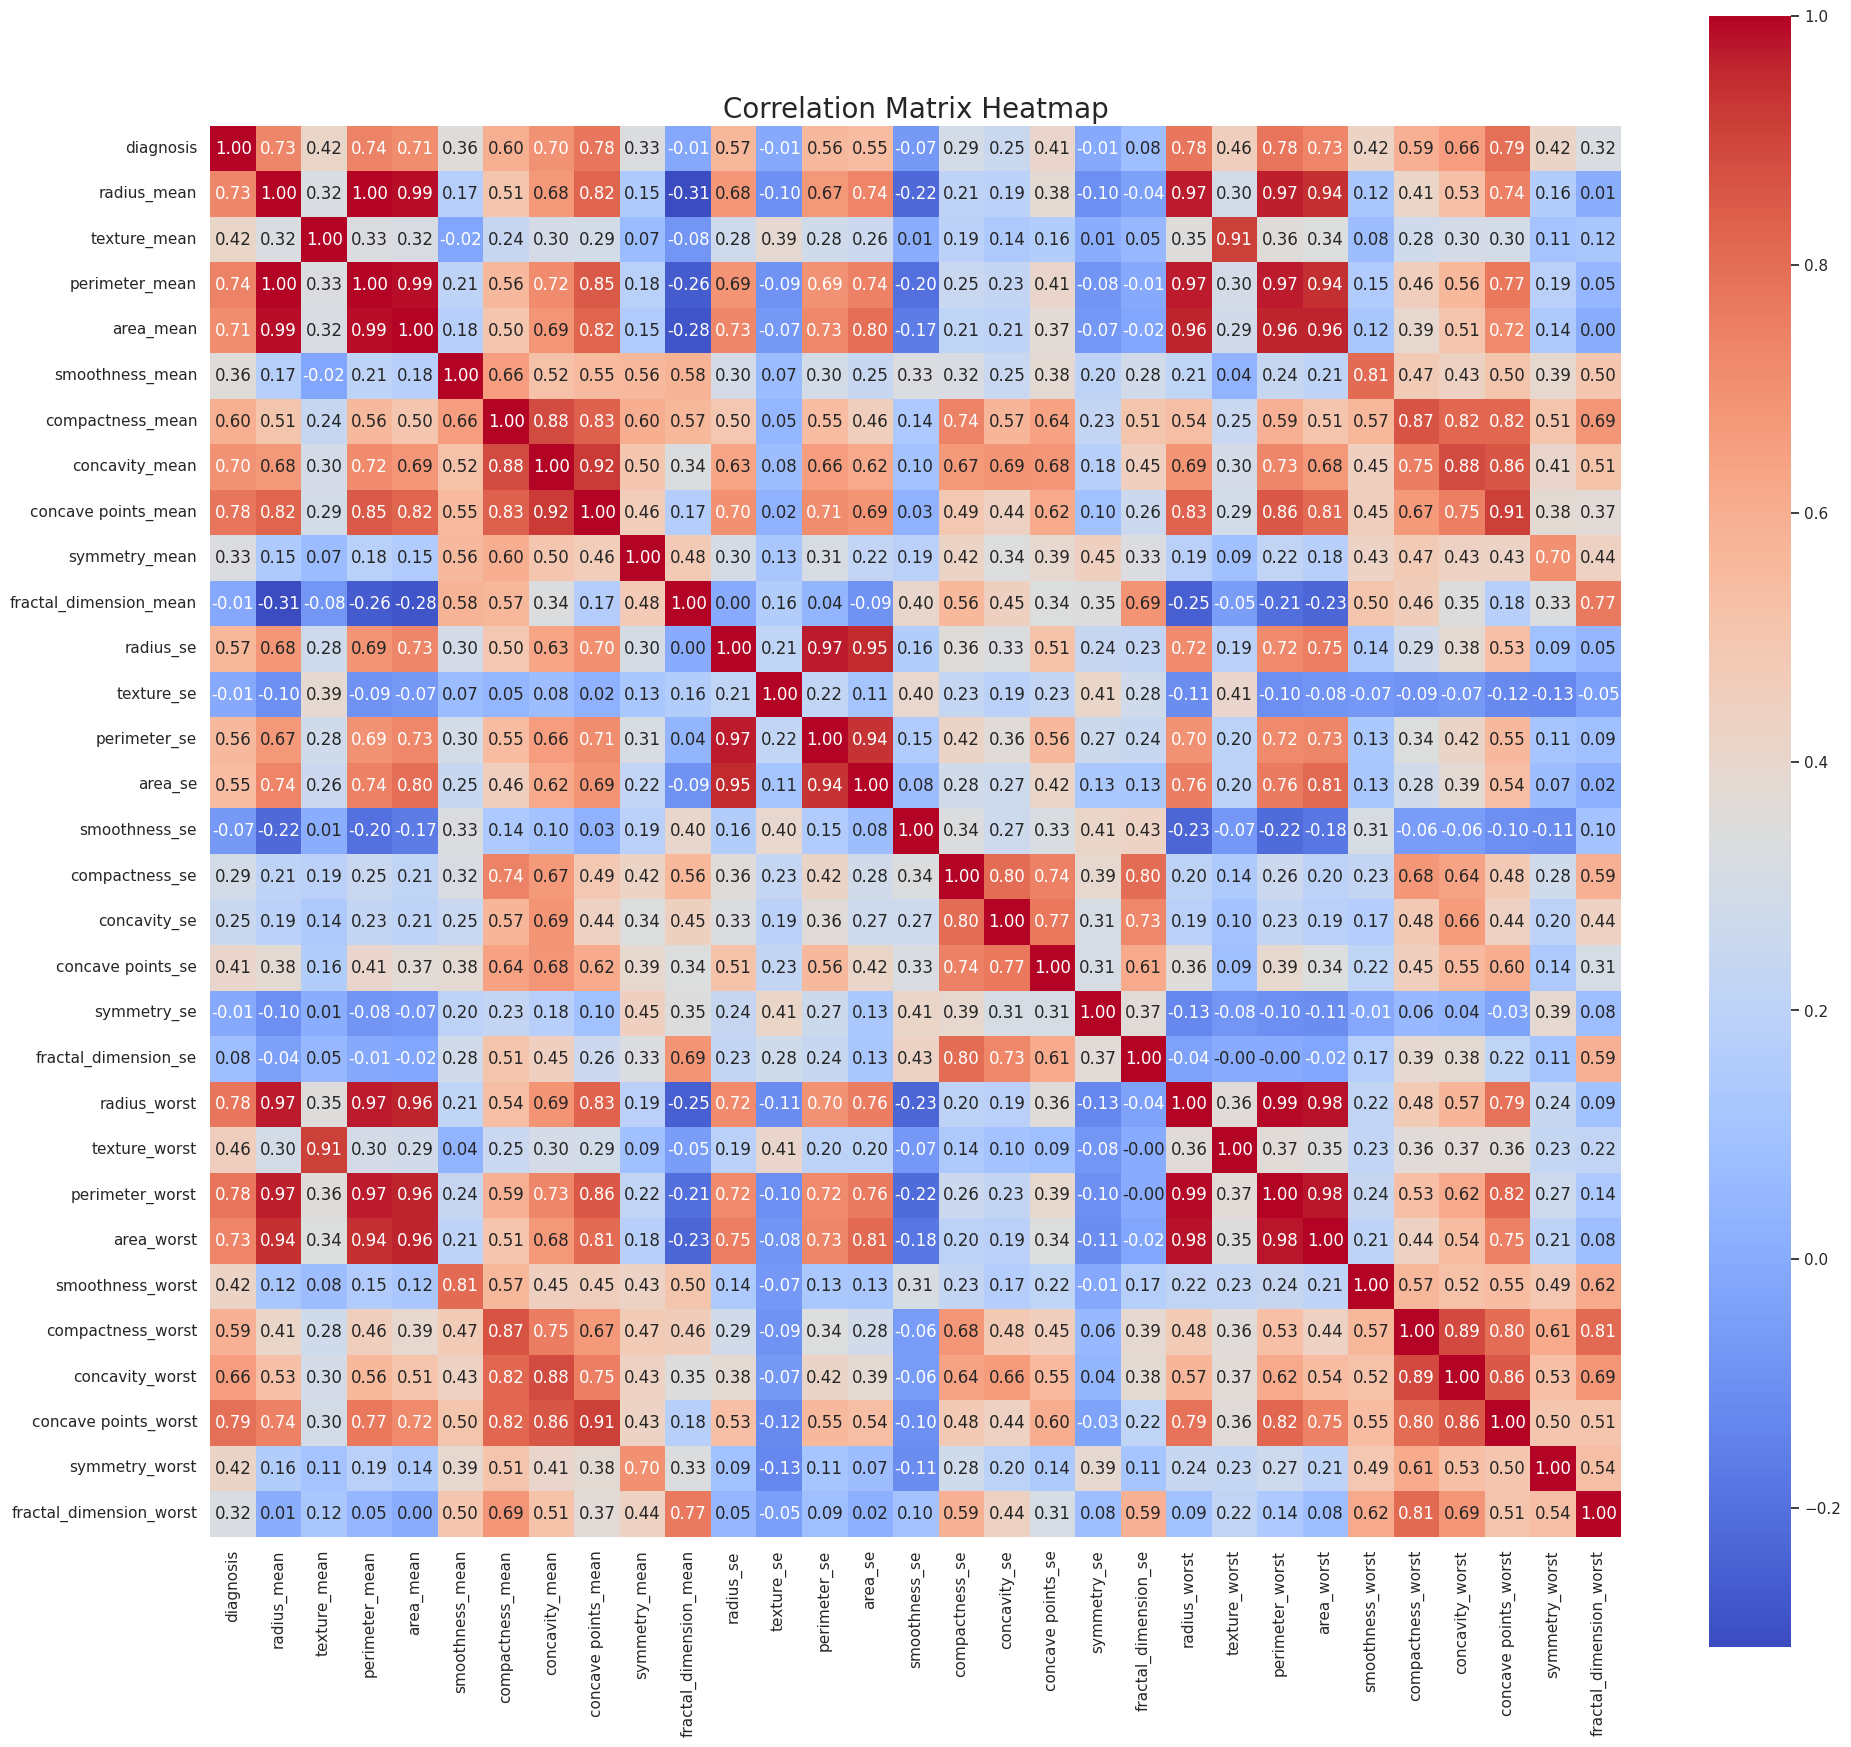

In [ ]:
# Correlation matrix heatmap

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

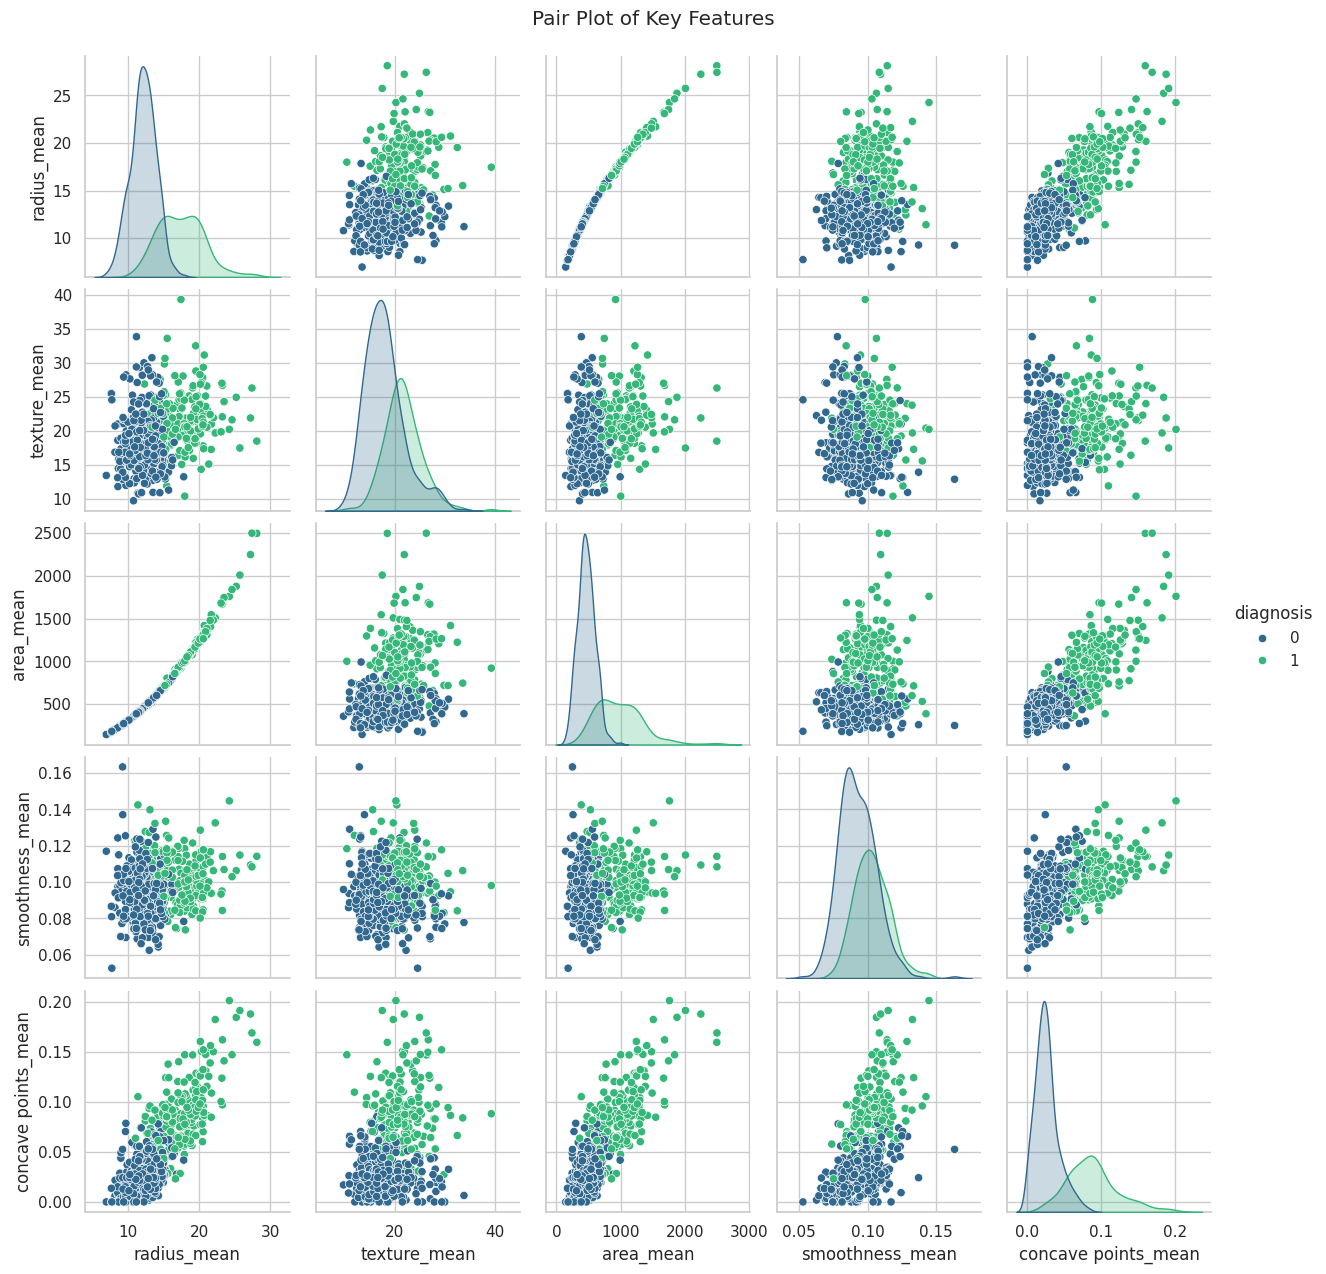

In [ ]:
# Pair plot for key features
# Define key features for the pair plot
key_features = ['radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean', 'concave points_mean']

# Create the pair plot
# hue='diagnosis' colors the points by the target variable
pair_plot = sns.pairplot(df, vars=key_features, hue='diagnosis', palette='viridis', diag_kind='kde')

# Set the title
pair_plot.fig.suptitle('Pair Plot of Key Features', y=1.02)

# Save the figure
pair_plot.savefig('key_features_pairplot.png')


--- 1. Clustering Analysis (Unsupervised) ---


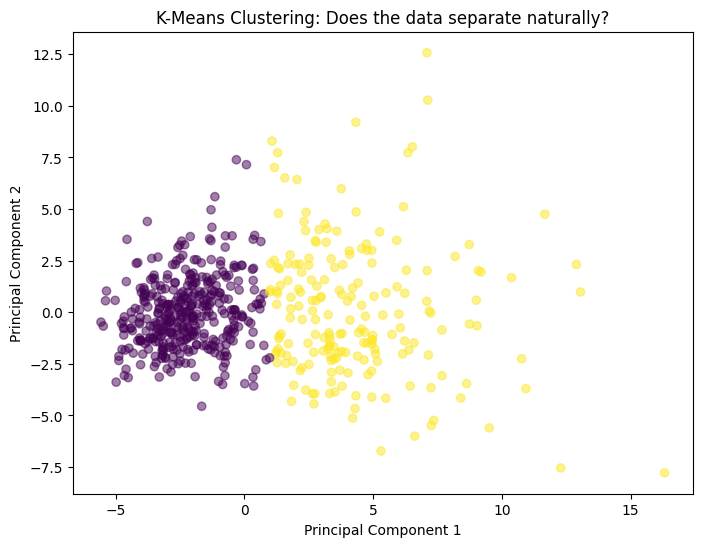

In [ ]:
# : UNSUPERVISED LEARNING (Clustering)

# Goal: See if data separates naturally without knowing the Diagnosis
print("\n--- 1. Clustering Analysis (Unsupervised) ---")

# Use PCA to reduce 30 dimensions to 2 so we can visualize it
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Visualize
plt.figure(figsize=(8, 6))
# Plot the AI's clusters vs The Real Diagnosis
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5, label='AI Clusters')
plt.title('K-Means Clustering: Does the data separate naturally?')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# COMPARING LINEAR, SVM, AND BOOSTING

import warnings
warnings.filterwarnings('ignore') # Suppress future warning on default solvers
from sklearn.metrics import mean_squared_error # Import mean_squared_error

print("\n--- 2. Model Comparison ---")

models = {
    "Logistic Regression": LogisticRegression(), # Linear approach
    "Support Vector Machine": SVC(probability=True), # For classification, probability=True for consistent API
    "XGBoost": XGBClassifier()
}


--- 2. Model Comparison ---


In [ ]:
# ADVANCED TUNING WITH OPTUNA (XGBoost)

print("\n--- 3. Optuna Tuning (Preventing Overfitting) ---")
print("Searching for best Regularization parameters...")

def objective(trial):
    # Define the Search Space (Regularization params)
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),

        # L1 and L2 Regularization (Required by your Methods doc)
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0), # L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), # L2

        # Optimization settings
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'verbosity': 0
        # FIX: Removed use_label_encoder from params dict
    }

    model = XGBClassifier(**param)

    # Cross Validation to ensure robustness
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Runs 20 experiments

print(f"Best Parameters found: {study.best_params}")


[I 2025-12-09 16:47:52,352] A new study created in memory with name: no-name-8087450b-155a-46d8-9ca7-f3071493658d



--- 3. Optuna Tuning (Preventing Overfitting) ---
Searching for best Regularization parameters...


[I 2025-12-09 16:47:54,986] Trial 0 finished with value: 0.969196584175671 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.10193915470918594, 'reg_alpha': 0.654626968274841, 'reg_lambda': 0.8092994911003394, 'subsample': 0.8711033825849254}. Best is trial 0 with value: 0.969196584175671.
[I 2025-12-09 16:47:56,797] Trial 1 finished with value: 0.9735970721505751 and parameters: {'n_estimators': 202, 'max_depth': 9, 'learning_rate': 0.0740571381652224, 'reg_alpha': 0.3081223619355321, 'reg_lambda': 0.9880949433053712, 'subsample': 0.693276476534572}. Best is trial 1 with value: 0.9735970721505751.
[I 2025-12-09 16:47:57,583] Trial 2 finished with value: 0.9648106192633903 and parameters: {'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.15182513580937984, 'reg_alpha': 0.6337452214972987, 'reg_lambda': 0.35501008645681653, 'subsample': 0.8785431107396255}. Best is trial 1 with value: 0.9735970721505751.
[I 2025-12-09 16:47:58,114] Trial 3 finished with va

Best Parameters found: {'n_estimators': 221, 'max_depth': 9, 'learning_rate': 0.06677038897233917, 'reg_alpha': 0.17763096884647833, 'reg_lambda': 0.5822576290184382, 'subsample': 0.5595540945704627}


In [ ]:
# Create comparison DataFrame
# Drop the 'id' column
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Group by diagnosis and calculate mean and median
comparison_df = df.groupby('diagnosis').agg(['mean', 'median'])

# Transpose for better readability (Features as rows)
comparison_df = comparison_df.transpose()

# Rename columns
comparison_df.columns = ['Benign', 'Malignant']

# Save to CSV
comparison_df.to_csv('comparison_dataframe.csv')

# Display
print(comparison_df.head())

                          Benign   Malignant
radius_mean    mean    12.146524   17.462830
               median  12.200000   17.325000
texture_mean   mean    17.914762   21.604906
               median  17.390000   21.460000
perimeter_mean mean    78.075406  115.365377


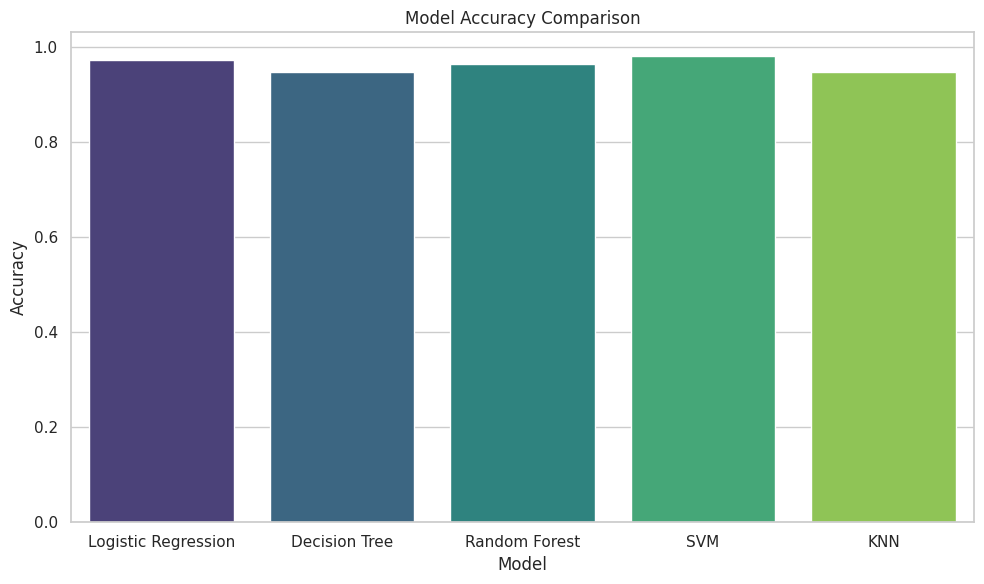

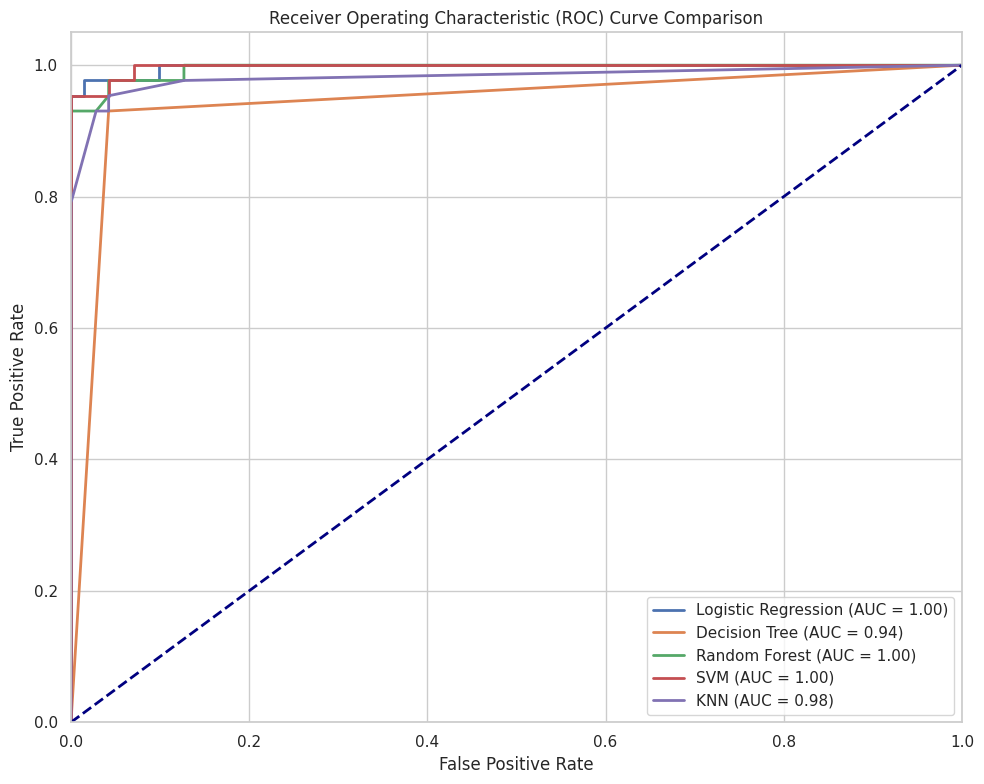

In [ ]:
# Visualize model comparison
# Preprocessing
# Drop 'id' column as it's not a feature
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# Encode the target variable
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis']) # M -> 1, B -> 0

# Split into features (X) and target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42), # probability=True for ROC curve
    'KNN': KNeighborsClassifier()
}

# Store results
results = []
roc_data = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Create a DataFrame for accuracy results
results_df = pd.DataFrame(results)

# Plot 1: Model Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Model', palette='viridis', legend=False)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
# plt.ylim(0.9, 1.0) # Optional: Zoom in to see differences
plt.tight_layout()
plt.savefig('model_accuracy_comparison.png')

# Plot 2: ROC Curves Comparison
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('model_roc_comparison.png')


--- 4. Final Regularized Model Evaluation ---
Final Training Accuracy: 99.78%
Final Testing Accuracy:  96.49%
Overfitting Gap:         3.29%


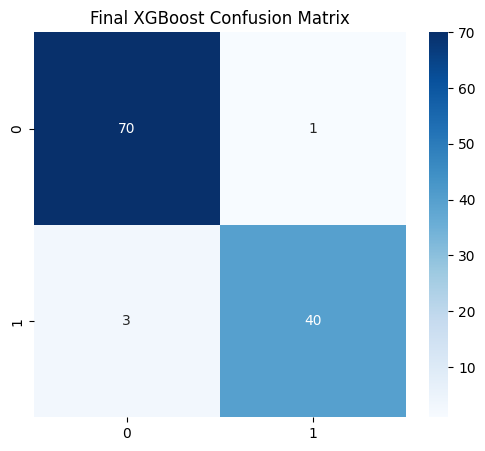

In [ ]:
# FINAL ROBUST EVALUATION

print("\n--- 4. Final Regularized Model Evaluation ---")

# Train with the BEST parameters found by Optuna
best_params = study.best_params
# FIX: Removed use_label_encoder=False from final model
final_model = XGBClassifier(**best_params, eval_metric='logloss')
final_model.fit(X_train, y_train)

# Gap Analysis
train_acc = final_model.score(X_train, y_train)
test_acc = final_model.score(X_test, y_test)

print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Testing Accuracy:  {test_acc*100:.2f}%")
print(f"Overfitting Gap:         {abs(train_acc - test_acc)*100:.2f}%")

# Confusion Matrix
preds = final_model.predict(X_test)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
plt.title('Final XGBoost Confusion Matrix')
plt.show()

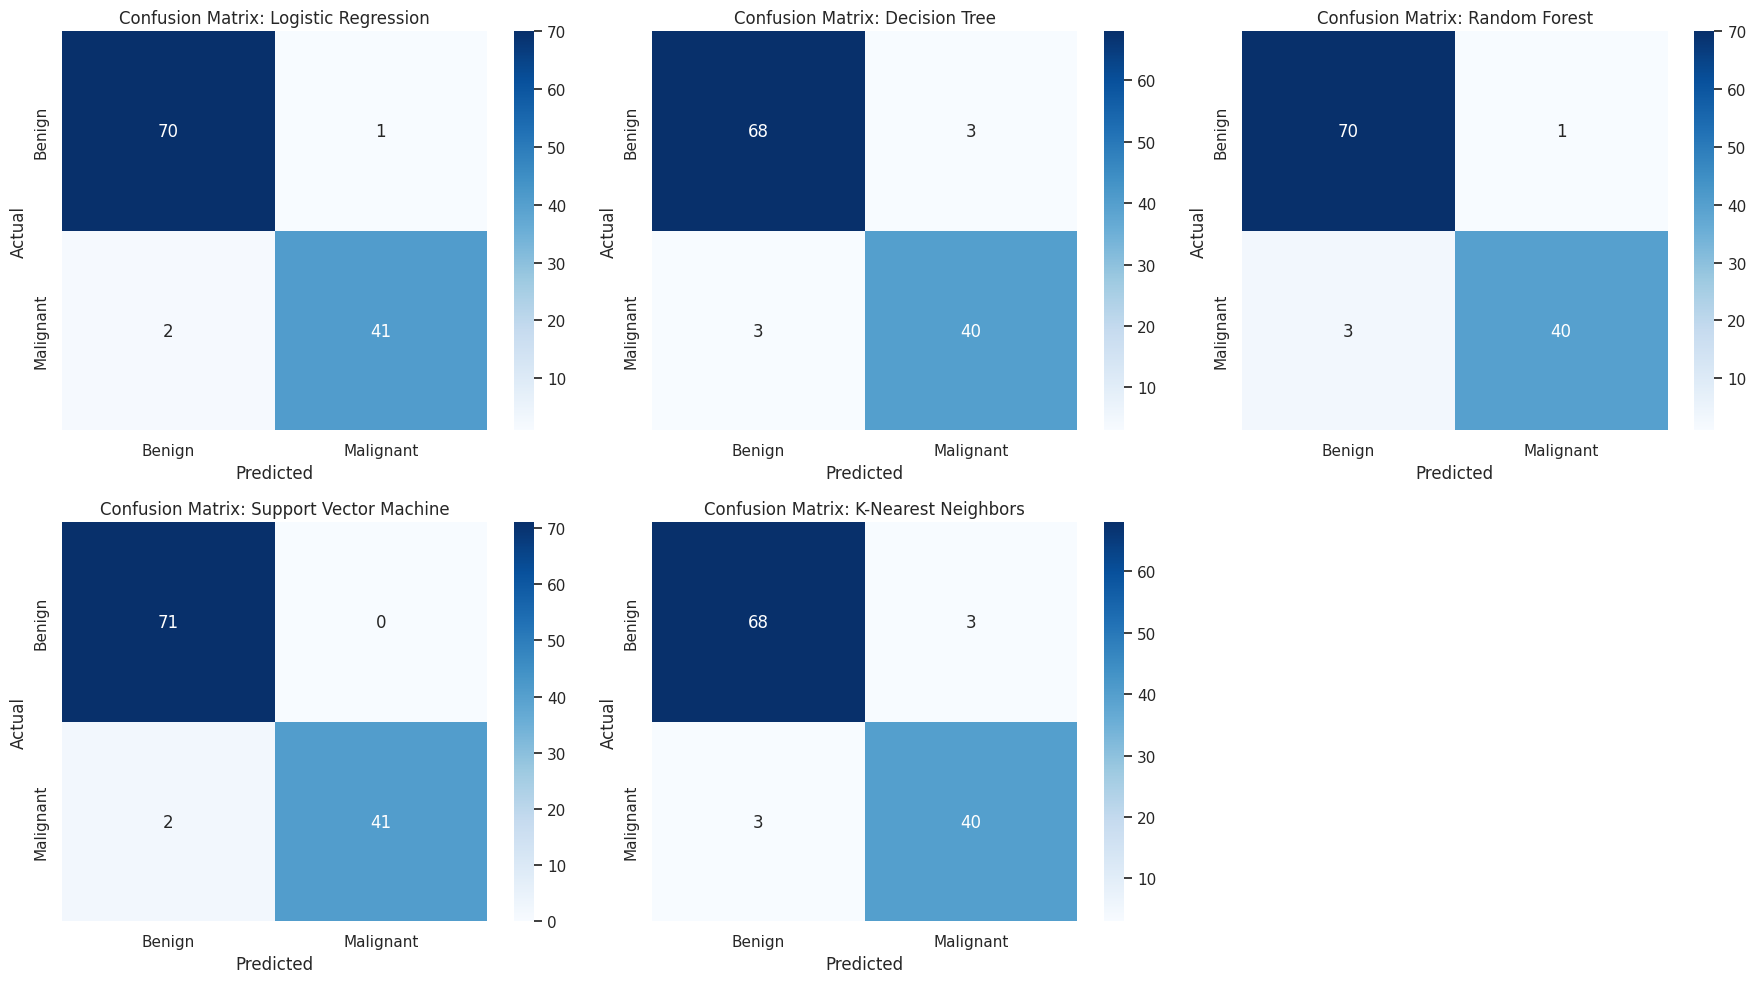

In [ ]:
# Confusion Matrices for all models
# Preprocessing
# Drop 'id' as it's not a feature
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

# Encode target variable (M=1, B=0)
# It's good practice to verify the encoding: usually B becomes 0 and M becomes 1
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for SVM and KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Calculate grid dimensions for plotting
n_models = len(models)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('confusion_matrices.png')

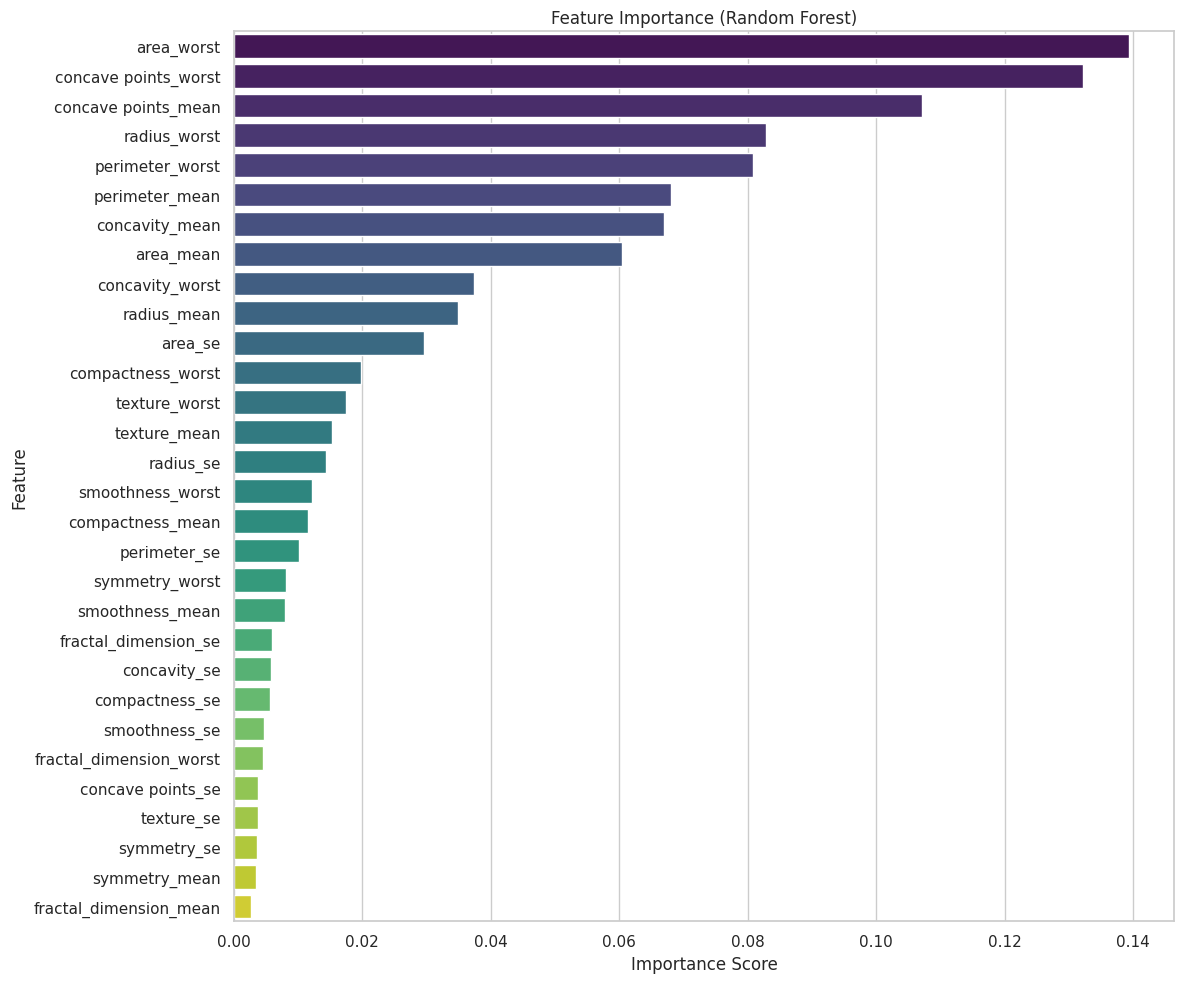

In [ ]:
# Feature importance for tree-based models
# Prepare the data
# Drop 'id' as it's not a feature. Also drop 'diagnosis' as it is the target.
X = df.drop(['diagnosis'], axis=1)

# Encode the target variable (M -> 1, B -> 0)
le = LabelEncoder()
y = le.fit_transform(df['diagnosis'])

# Initialize and train the Random Forest Classifier
# n_estimators=100 creates a forest with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization and sort by importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance_rf.png')

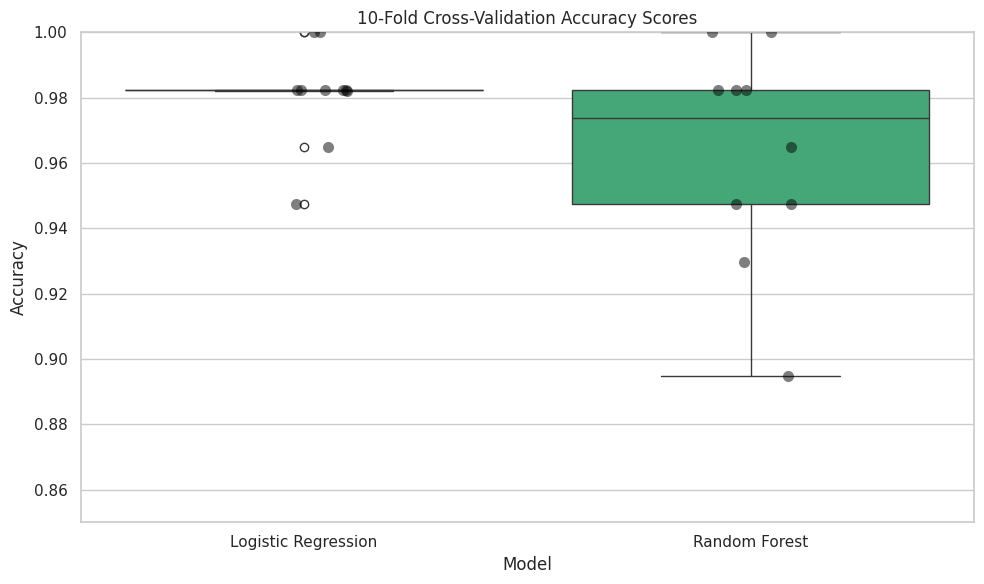

In [ ]:
# Cross-validation scores
# Preprocessing
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['diagnosis']) # M -> 1, B -> 0
# Drop 'id' and 'diagnosis' to get features
X = df.drop(['diagnosis'], axis=1)

# Define models to test
# We'll use a Pipeline for Logistic Regression to include scaling
from sklearn.pipeline import Pipeline # Import Pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

rf_model = RandomForestClassifier(random_state=42)

models = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': rf_model
}

# Store results
cv_results = []

# Perform Cross-Validation (10-fold)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    for score in scores:
        cv_results.append({'Model': name, 'Accuracy': score})

# Create a DataFrame for visualization
cv_df = pd.DataFrame(cv_results)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Accuracy', data=cv_df, palette='viridis', hue='Model', legend=False)
sns.stripplot(x='Model', y='Accuracy', data=cv_df, size=8, color='black', alpha=0.5, jitter=True)
plt.title('10-Fold Cross-Validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)
plt.tight_layout()
plt.savefig('cv_scores.png')

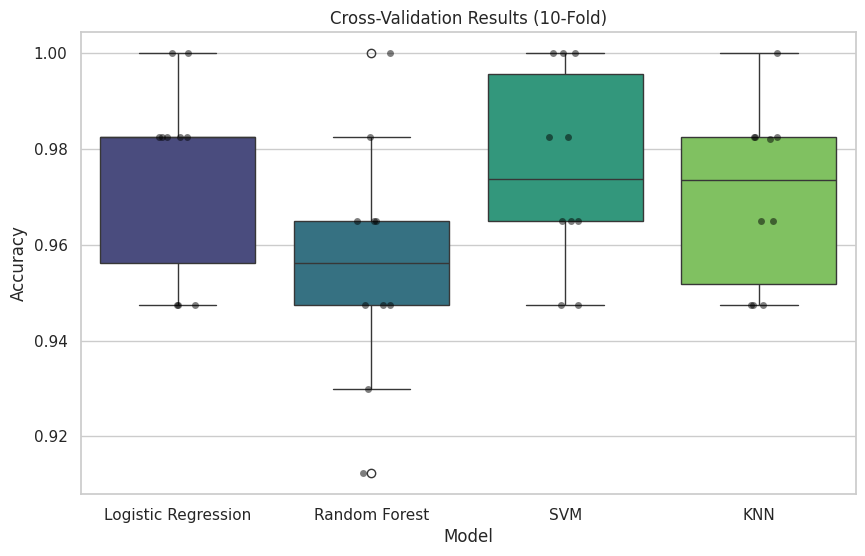

In [ ]:
# Visualize cross-validation results
# Preprocessing
# Re-load data to ensure consistent state and re-apply all preprocessing steps
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load the original data
df = pd.read_csv('breast-cancer.csv')

# Re-apply preprocessing steps from earlier cells
df.dropna(axis=1, how='all', inplace=True) # Drop empty columns
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True) # Drop ID
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True) # Drop duplicates
df.fillna(df.mean(numeric_only=True), inplace=True) # Handle Missing Values

# Encode target variable
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis']) # M -> 1, B -> 0

# Separate features and target
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

# Define models to compare
models = [
    ('Logistic Regression', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('SVM', make_pipeline(StandardScaler(), SVC(random_state=42))),
    ('KNN', make_pipeline(StandardScaler(), KNeighborsClassifier()))
]

# Perform Cross-Validation
results = []
names = []
scoring = 'accuracy'
cv_folds = 10

# Collect results
for name, model in models:
    kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_scores)
    names.append(name)

# Create a DataFrame for visualization
results_df = pd.DataFrame(results).T
results_df.columns = names
results_melted = results_df.melt(var_name='Model', value_name='Accuracy')

# Visualization
plt.figure(figsize=(10, 6))
# Box plot to show distribution
sns.boxplot(x='Model', y='Accuracy', data=results_melted, palette='viridis', hue='Model', legend=False)
# Strip plot to show individual data points
sns.stripplot(x='Model', y='Accuracy', data=results_melted, color='black', alpha=0.5, jitter=True)
plt.title(f'Cross-Validation Results ({cv_folds}-Fold)')
plt.ylabel('Accuracy')
plt.savefig('cross_validation_results.png')

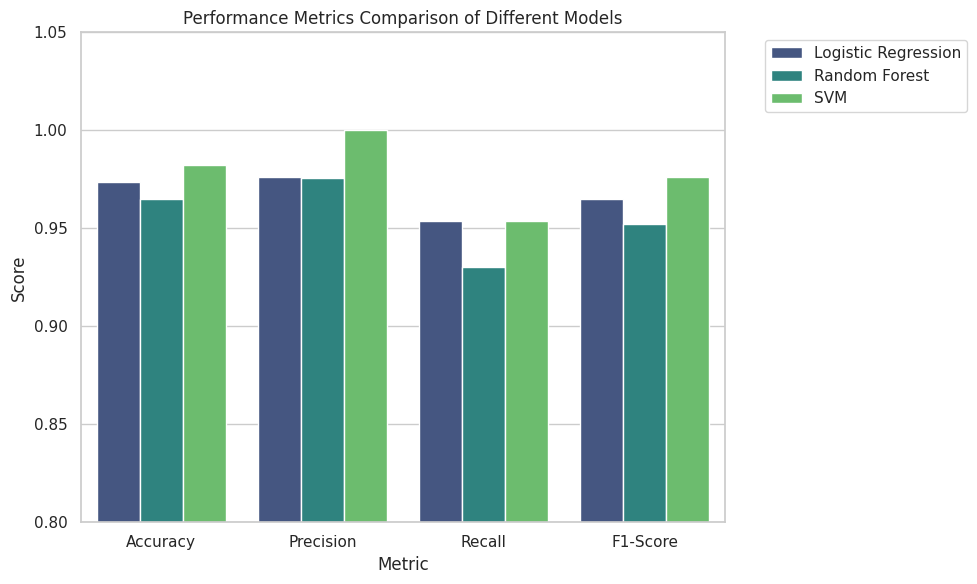

In [ ]:
# Performance metrics comparison chart
# Preprocessing
# Encode the target variable
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

# Drop 'id' and any other non-feature columns
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (important for Logistic Regression and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Import metrics needed for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Train and evaluate
for name, model in models.items():
    if name == 'Random Forest':
        # Random Forest generally doesn't require scaling, but can use it.
        # Using raw data here to be distinct.
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)

    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, preds))
    results['Precision'].append(precision_score(y_test, preds))
    results['Recall'].append(recall_score(y_test, preds))
    results['F1-Score'].append(f1_score(y_test, preds))

# Create DataFrame
results_df = pd.DataFrame(results)

# Melt for easier plotting with seaborn
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Performance Metrics Comparison of Different Models')
plt.ylim(0.8, 1.05) # Adjust limits to show differences clearly
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('performance_metrics_comparison.png')

Classification Report:
              precision    recall  f1-score   support

           B       0.97      1.00      0.99        71
           M       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



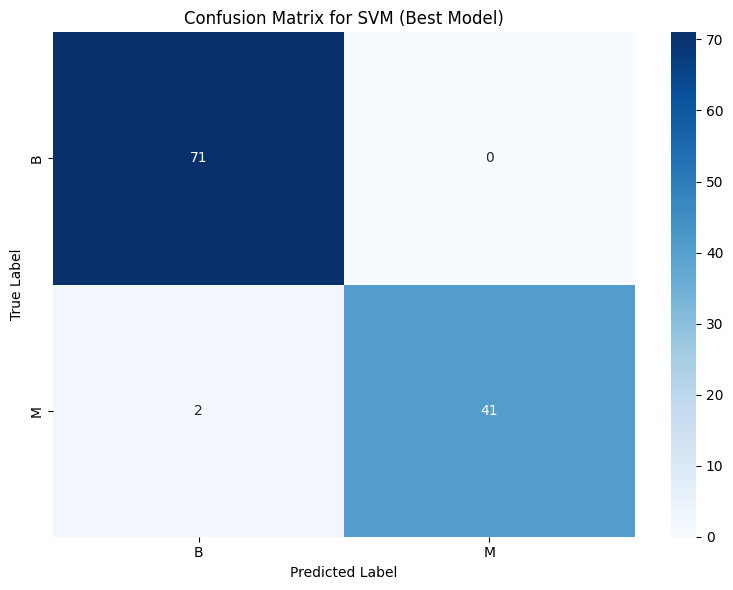

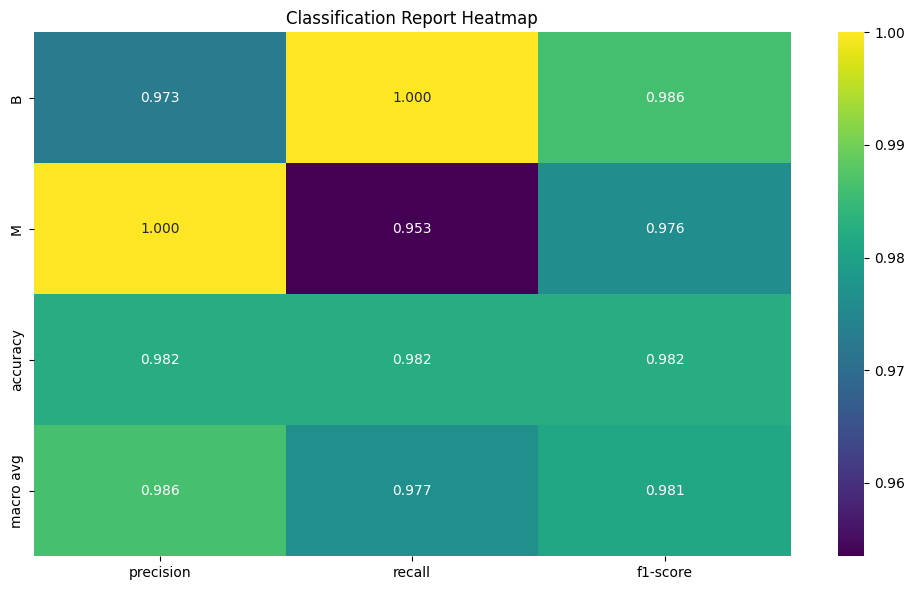

In [ ]:
# Detailed classification report for the best model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Preprocessing
# Assuming 'df' and its 'diagnosis' column are already preprocessed and encoded
# if not, these lines would need to be re-run with original data
le = LabelEncoder()
# Re-fit_transform the diagnosis column to ensure le.classes_ is correctly populated
# This assumes df already contains the original string labels for diagnosis, if not, it will just re-encode the numeric labels
# To avoid issues, let's re-load data and preprocess if needed, as in other cells

# Re-load data to ensure consistent state and re-apply all preprocessing steps
df = pd.read_csv('breast-cancer.csv')

# Re-apply preprocessing steps from earlier cells
df.dropna(axis=1, how='all', inplace=True) # Drop empty columns
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True) # Drop ID
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True) # Drop duplicates
df.fillna(df.mean(numeric_only=True), inplace=True) # Handle Missing Values

le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

X = df.drop(['diagnosis'], axis=1) # 'id' column was already dropped in earlier cells
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the best model (SVM)
best_model = SVC(random_state=42)
best_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = best_model.predict(X_test_scaled)

# Print Text Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 1. Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for SVM (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')

# 2. Visualizing the Classification Report as a Heatmap
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
# Exclude support column for color scaling balance, and accuracy row
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt='.3f')
plt.title('Classification Report Heatmap')
plt.tight_layout()
plt.savefig('classification_report_heatmap.png')